In [1]:
import os
import numpy as np
from scipy.io import loadmat
from torch.utils.data import Dataset, DataLoader
import torch

#Channel auswählen
SELECTED_CHANNELS = ['accel01x', 'accel02x', 'accel03x', 'accel04x', 'accel05x', 'accel06x', 'accel07x','accel08x','accel09x']
WINDOW_SIZE = 300

In [2]:
mat_path = r'D:\Bauingenieur\studienprojekt2\Daten\exemplary_datasets_dam3_010\11_Healthy\SHMTS_202106150008' #matlab 
data = loadmat(mat_path)
varname = [k for k in data if not k.startswith('__')][0]
record = data[varname][0, 0]

channel_names = [ch[0] for ch in record[3][0]]
acc_data = record[5]
fs = record[2][0, 0]

indices = [channel_names.index(ch) for ch in SELECTED_CHANNELS]
max_samples = int(fs * 60)
selected_data = acc_data[:max_samples, indices]
original_data = selected_data.copy()
mean = selected_data.mean(axis=0)       
std = selected_data.std(axis=0) 
selected_data_mask = (selected_data - mean) / std


    



In [3]:
def mask_channel(X, channel_idx):

    
    X_masked = X.clone()
    if isinstance(channel_idx, int):
        channel_idx = [channel_idx]
    X_masked[:, :, channel_idx] = 0
    return X_masked 

In [4]:
def create_sequences(data, window_size): #Dateset
    sequences = []
    for i in range(len(data) - window_size):
        window = data[i:i + window_size]
        sequences.append(window)
    return np.array(sequences)

X = create_sequences(selected_data_mask, WINDOW_SIZE)  
y = np.zeros(len(X))  

In [5]:


class SingleFileDataset(Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]

dataset = SingleFileDataset(X)
loader = DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=0,pin_memory=True)

In [6]:
import torch.nn as nn

class Encoder(nn.Module): #编码器
    def __init__(self, input_size=6, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=9, hidden_size=64, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)  
        self.linear1 = nn.Linear(64, 16)
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = self.linear1(x)
        return x 

In [7]:
class Decoder(nn.Module):
    def __init__(self): #解码器
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=16, hidden_size=64, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)  
        self.linear1 = nn.Linear(64, 9)
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = self.linear1(x)
        
        return x 

In [8]:
class LSTMAutoEncoder(nn.Module): #lstm编码器解码器组合，瓶颈形状。
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}") #测试cuda

Using device: cuda


In [10]:
import torch.optim as optim
import matplotlib.pyplot as plt #训练

model = LSTMAutoEncoder()
model.to(device)
model = torch.compile(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.MSELoss()

train_losses = []

for epoch in range(10):
    model.train()
    epoch_loss = 0

    for X_batch in loader:
        X_batch = X_batch.to(device)
        X_masked = mask_channel(X_batch, channel_idx=4)
        optimizer.zero_grad()
        output = model(X_masked)
        loss = criterion(output, X_batch)  
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        epoch_loss += loss.item()
    
    train_loss = np.mean(train_losses)
    #avg_loss = epoch_loss / len(loader)
    #train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {train_loss:.6f}")

Epoch 1, Loss: 0.203321
Epoch 2, Loss: 0.142233
Epoch 3, Loss: 0.117624
Epoch 4, Loss: 0.100345
Epoch 5, Loss: 0.085834
Epoch 6, Loss: 0.075075
Epoch 7, Loss: 0.067040
Epoch 8, Loss: 0.060751
Epoch 9, Loss: 0.055784
Epoch 10, Loss: 0.051695


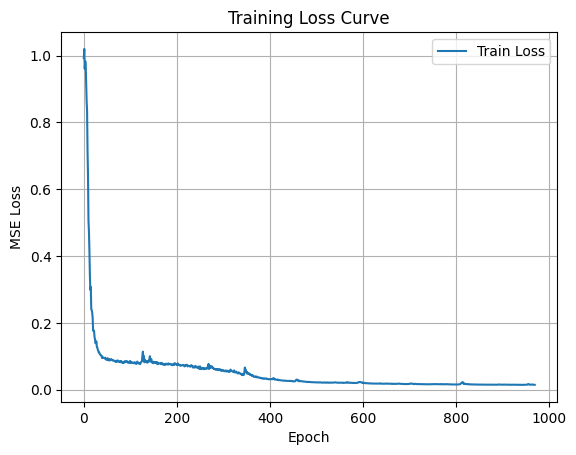

In [11]:
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.legend()
plt.show()

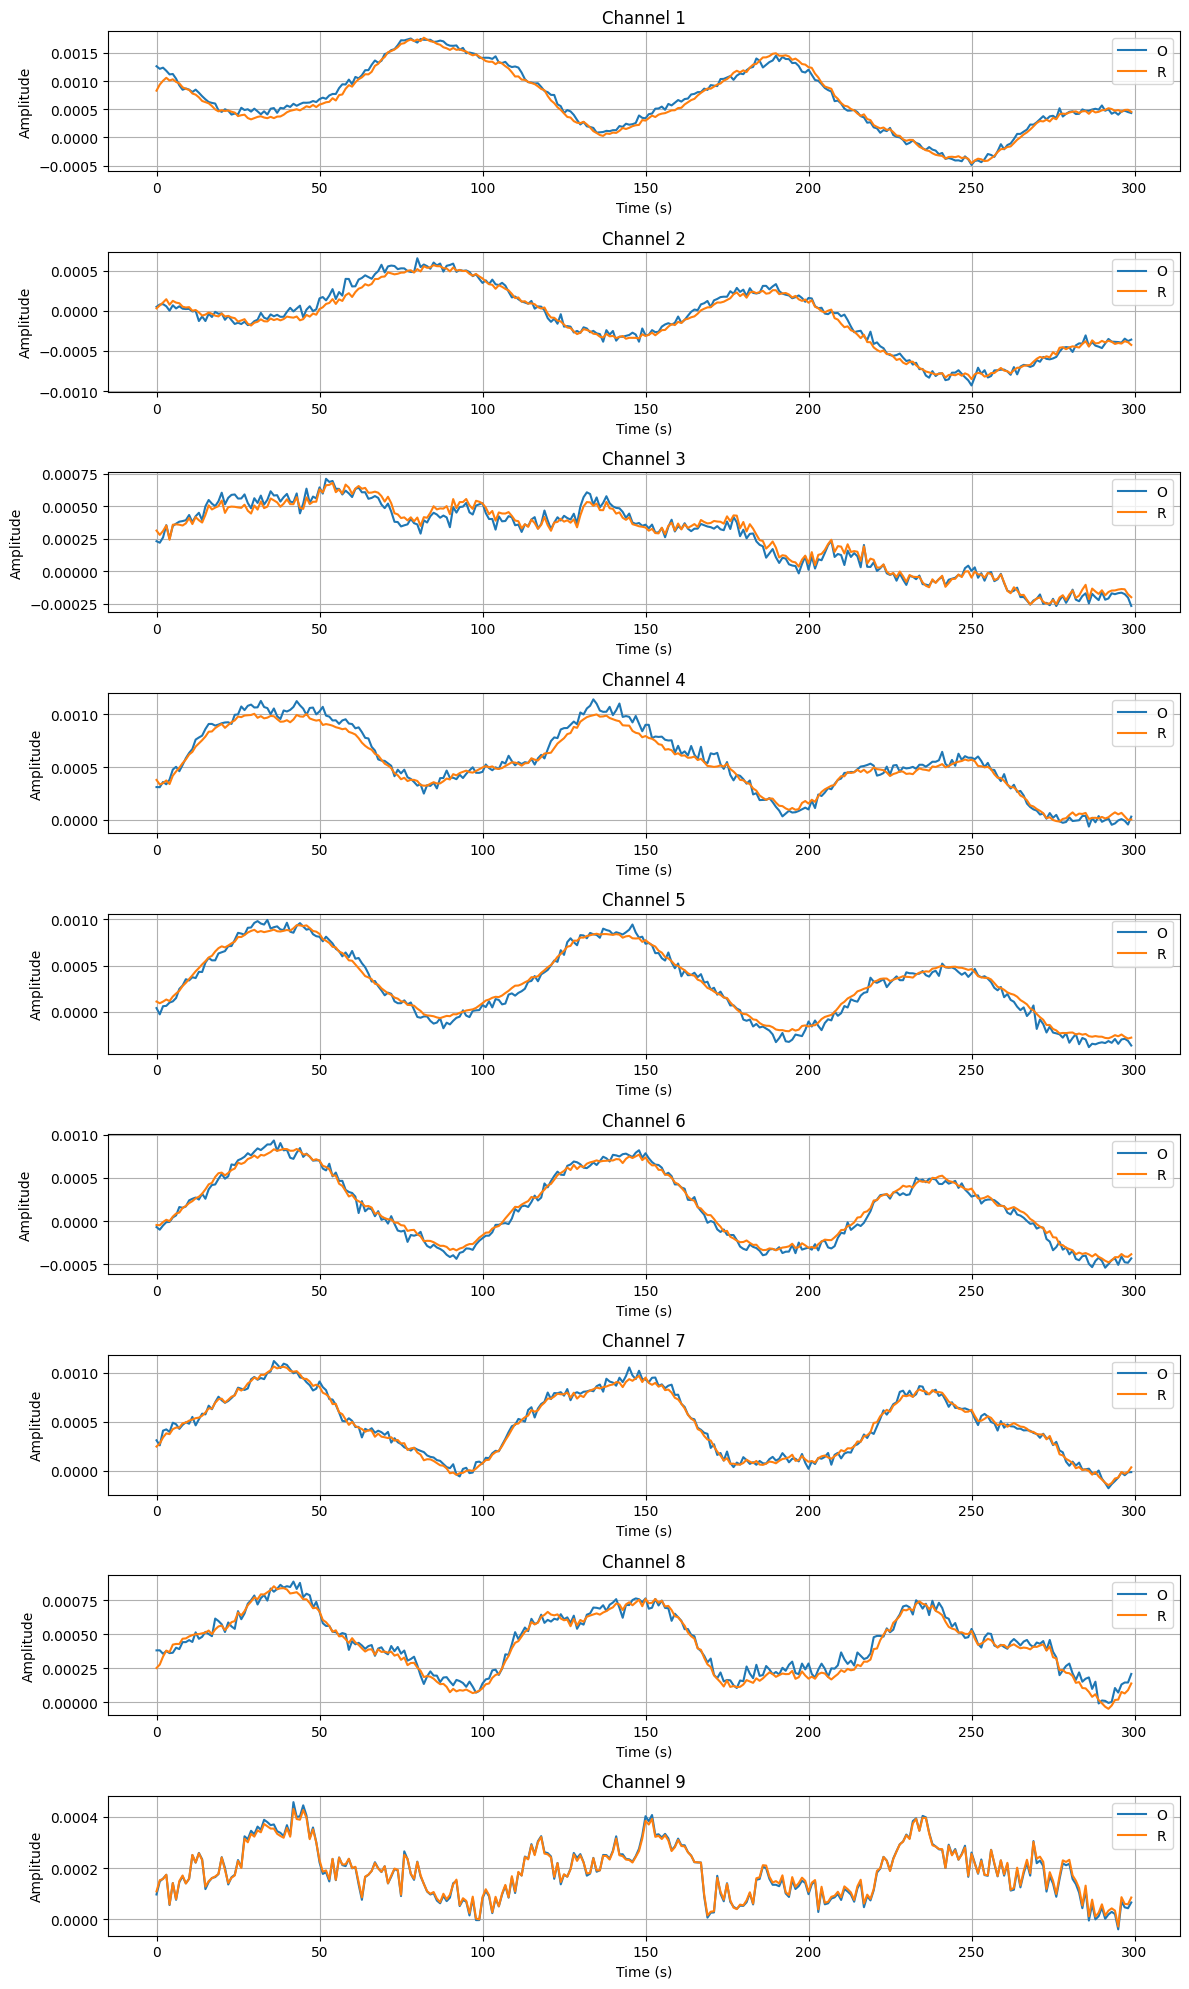

In [38]:

model.eval()
sample = dataset[0].unsqueeze(0).to(device)  


with torch.no_grad():
    #reconstructed = model(full_input).cpu().squeeze(0).numpy()  
    reconstructed = model(sample).cpu().squeeze(0).numpy()
    reconstructed_original = reconstructed * std + mean
#original = selected_data 
original = sample.cpu().squeeze(0).numpy() * std + mean

fs = 1651.61  
#time = np.arange(original.shape[0]) / fs  
time = np.arange(sample.shape[1])

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 20))
for i in range(original.shape[1]):  
    plt.subplot(original.shape[1], 1, i + 1)
    plt.plot(time, original[:, i], label='O')
    plt.plot(time, reconstructed_original[:, i], label='R')
    plt.title(f'Channel {i+1}')
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

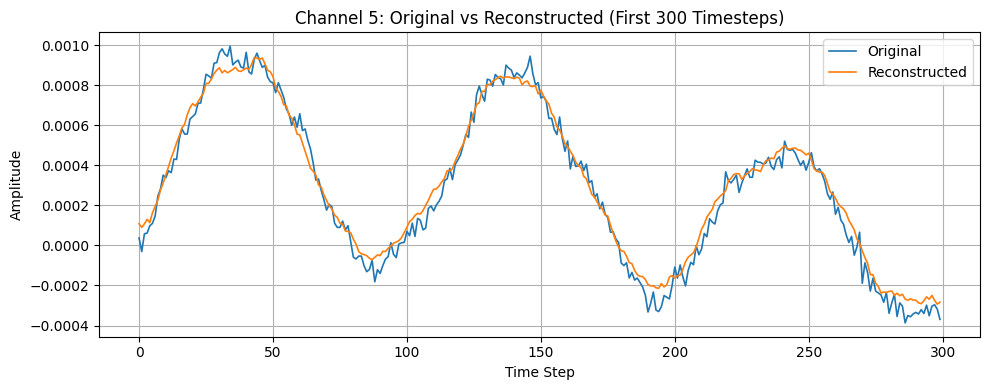

In [39]:
num_steps = 300
channel = 4 




# 取第3通道
original_ch = original_data[:num_steps, channel]
reconstructed_ch = reconstructed_original[:, channel]


# time = np.arange(num_steps) / fs  
time = np.arange(num_steps)

# 绘图
plt.figure(figsize=(10, 4))
plt.plot(time, original_ch, label="Original", linewidth=1.2)
plt.plot(time, reconstructed_ch, label="Reconstructed", linewidth=1.2)
plt.title(f"Channel {channel+1}: Original vs Reconstructed (First 300 Timesteps)")
plt.xlabel("Time Step")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [46]:

def single_channel_accuracy(preds, targets, threshold):
    """
    preds, targets: [samples], 1D tensor
    threshold: float, maximum allowed absolute error for correct prediction
    """
    error = torch.abs(preds - targets)
    correct = (error < threshold).float().sum().item()
    total = preds.shape[0]
    return correct / total
if isinstance(reconstructed_ch, np.ndarray):
    reconstructed_ch = torch.from_numpy(reconstructed_ch)

if isinstance(original_ch, np.ndarray):
    original_ch = torch.from_numpy(original_ch)
acc = single_channel_accuracy(reconstructed_ch, original_ch, threshold=0.00005)
print(f"准确率: {acc:.2%}")


准确率: 63.00%


In [47]:

def mape(preds, targets):
    
    return torch.mean(torch.abs((preds - targets) / (targets ))) * 100

error=mape(reconstructed_ch, original_ch)
print(f"MAPE: {error:.2f}%")

MAPE: 38.08%


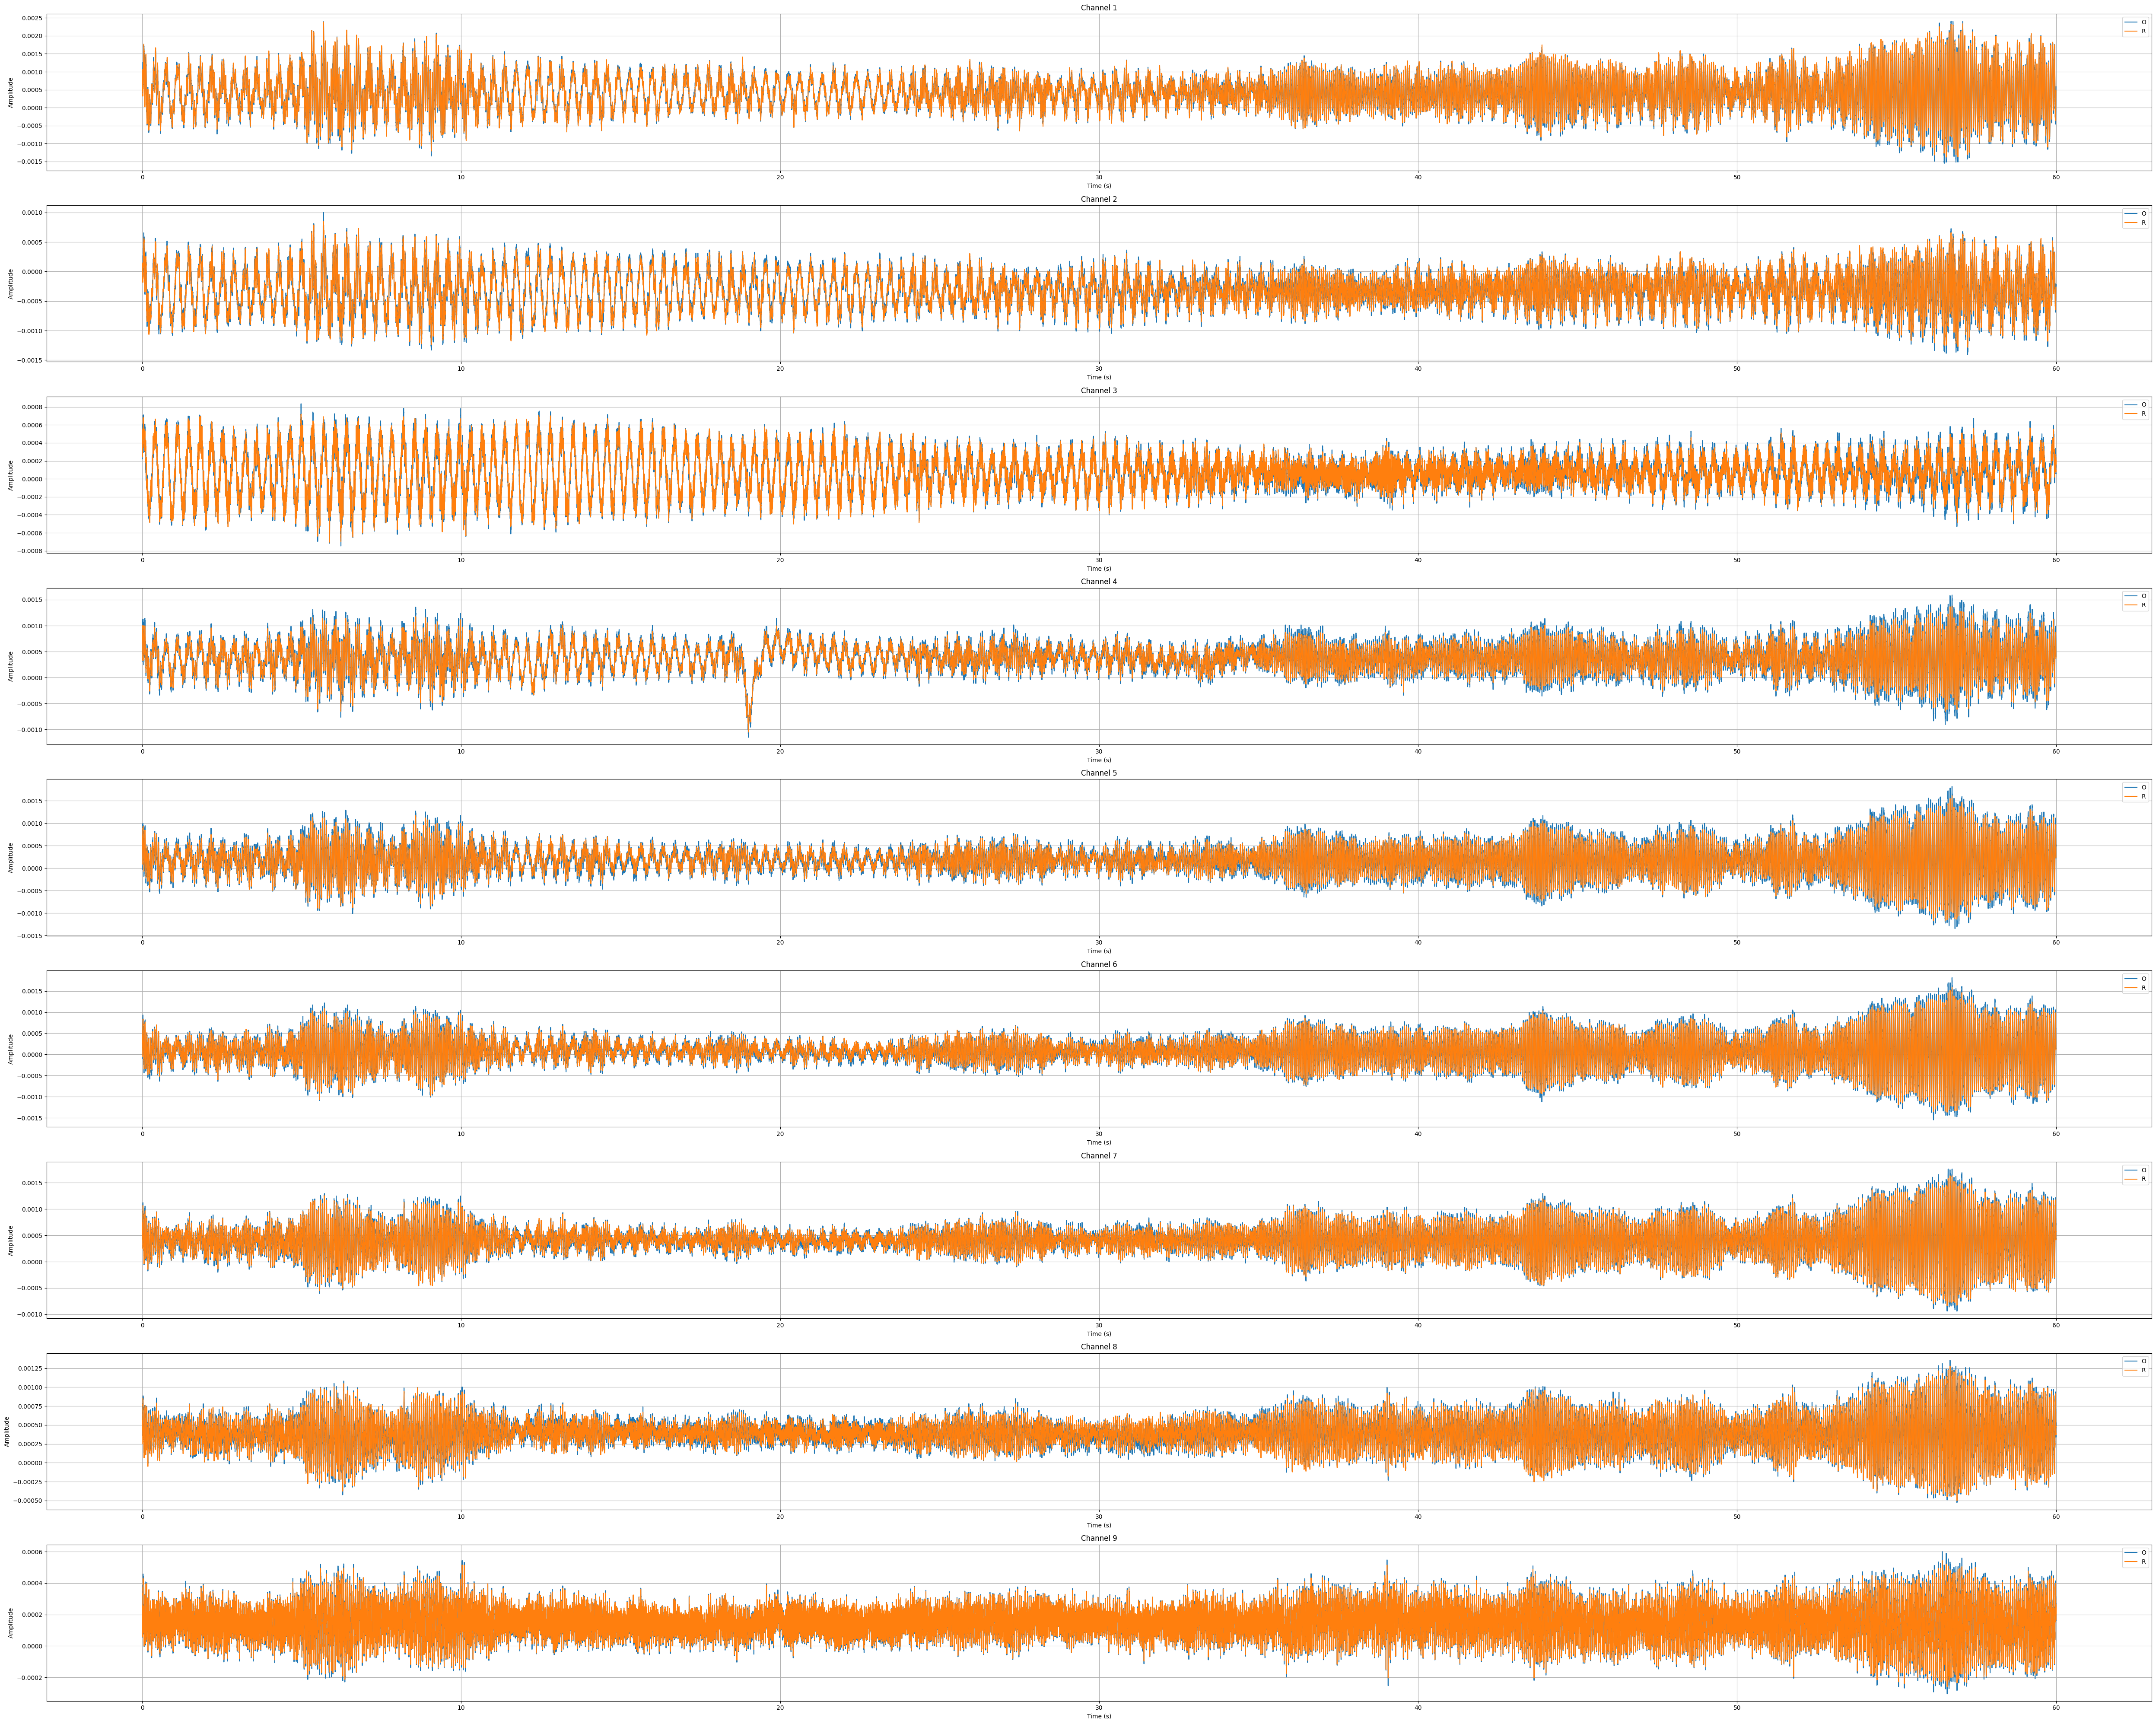

In [49]:

normalized_input = (selected_data - mean) / std
full_input = torch.tensor(normalized_input, dtype=torch.float32).unsqueeze(0).to(device)
model.eval()



with torch.no_grad():
    reconstructed1 = model(full_input)
    reconstructed1 = reconstructed1.cpu().squeeze(0).numpy() 
    reconstructed_original = reconstructed1 * std + mean
original1 = selected_data 


fs = 1651.61  
time = np.arange(original1.shape[0]) / fs  


import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))
for i in range(original1.shape[1]):  
    plt.subplot(original1.shape[1], 1, i + 1)
    plt.plot(time, original1[:, i], label='O')
    plt.plot(time, reconstructed_original[:, i], label='R')
    plt.title(f'Channel {i+1}')
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [61]:
import torch
import numpy as np

def single_channel_accuracy(preds, targets, threshold):
    """
    preds, targets: 1D tensor [samples]
    threshold: float, maximum allowed absolute error
    """
    preds = torch.as_tensor(preds)
    targets = torch.as_tensor(targets)
    error = torch.abs(preds - targets)
    correct = (error < threshold).float().sum().item()
    total = preds.shape[0]
    return correct / total

def multi_channel_accuracy(preds, targets, threshold):
    """
    preds, targets: 2D tensor [T, C]  (时间步，通道数)
    threshold: float, maximum allowed absolute error
    Returns: list of accuracy per channel
    """
    preds = torch.as_tensor(preds)
    targets = torch.as_tensor(targets)
    assert preds.shape == targets.shape, "Shape mismatch"
    channel_accuracies = []
    for ch in range(preds.shape[1]):
        acc = single_channel_accuracy(preds[:, ch], targets[:, ch], threshold)
        channel_accuracies.append(acc)
    return channel_accuracies

# 假设 reconstructed_original 和 original 都是 [T, C] 的 numpy 数组
if isinstance(reconstructed1, np.ndarray):
    reconstructed1 = torch.from_numpy(reconstructed)
else:
    reconstructed1 = reconstructed

if isinstance(original, np.ndarray):
    original1 = torch.from_numpy(original)
else:
    original1 = original

# 计算每个通道的准确率
threshold = 1  # 允许误差
accuracies = multi_channel_accuracy(reconstructed1, original1, threshold)

# 输出
for i, acc in enumerate(accuracies):
    print(f"Channel {i+1} 准确率: {acc:.2%}")

Channel 1 准确率: 58.67%
Channel 2 准确率: 47.33%
Channel 3 准确率: 30.67%
Channel 4 准确率: 63.33%
Channel 5 准确率: 64.00%
Channel 6 准确率: 63.00%
Channel 7 准确率: 56.00%
Channel 8 准确率: 58.67%
Channel 9 准确率: 68.67%
